# Implementation of a KAN for regression
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of regression and compare it against a neural network of a similar architecture.

## Initialisations

In [7]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


## Loading the Dataset

In [8]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, 8, device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, 8, device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)

    return dataset

calhous_dataset = load_calhous_dataset()

100%|██████████| 4128/4128 [00:00<00:00, 12460.39it/s]


In [ ]:
print("Train data shape: {}".format(calhous_dataset['train_input'].shape))
print("Train target shape: {}".format(calhous_dataset['train_label'].shape))
print("Test data shape: {}".format(calhous_dataset['test_input'].shape))
print("Test target shape: {}".format(calhous_dataset['test_label'].shape))
print("====================================")

## Creating and Training the KAN

In [9]:
image_folder = 'video_img'
model_index = 5

model = KAN(width=[8, 3, 1], grid=3, k=3, seed=model_index, device=device)

In [ ]:
x = torch.normal(0,1,size=(100,8)).to(device)
model(x) # do a forward pass to obtain model.acts
# model.get_range(0,0,0)
print(f"{model.act_fun[0].grid[0].data=}") # Check the initial grid, size = grid + 1
print(f"{model.act_fun[0].coef[0].data=}")  # Check the initial coef, size = grid + k

In [10]:
def train_mse():
    with torch.no_grad():
        predictions = model(calhous_dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, calhous_dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(calhous_dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, calhous_dataset['test_label'])
    return mse

# results = model.train(calhous_dataset, opt="LBFGS", device=device, metrics=(train_mse, test_mse),
#                       loss_fn=torch.nn.MSELoss(), steps=50, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

results = model.train(calhous_dataset, opt="LBFGS", device=device, metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=100, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

train loss: 5.57e-01 | test loss: 5.80e-01 | reg: 3.62e+00 : 100%|█| 100/100 [04:23<00:00,  2.63s/it


In [11]:
print(f"Train MSE: {results['train_mse'][-1]:.5f}, Test MSE: {results['test_mse'][-1]:.5f}")

Train MSE: 0.31013, Test MSE: 0.33585


In [ ]:
def detect_inference_time():
    import random
    import time

    # 从测试集中随机选择一个样本
    index = random.randint(0, len(calhous_dataset['test_input']) - 1)
    input_data = calhous_dataset['test_input'][index].unsqueeze(0)
    label = calhous_dataset['test_label'][index]

    # 将输入数据传入模型进行预测
    start = time.time()
    with torch.no_grad():
        output = model(input_data)
    end = time.time()
    # print(f"Inference time: {end - start} seconds")
    return end - start

def print_act():
    for i in model.acts_scale:
        print(i)
        print('\n\n')

time = []
for i in range(11):
    time.append(detect_inference_time())
print(time)
print(sum(time[1:]) / (len(time)-1))
# print_act()

In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

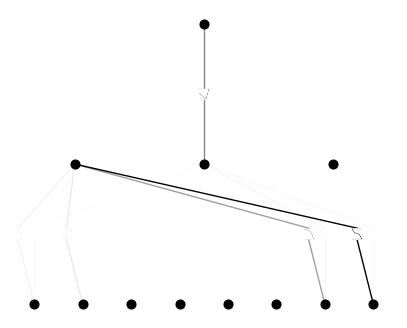

In [6]:
model.plot()

In [ ]:
import moviepy.video.io.ImageSequenceClip

video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

In [ ]:
import imageio
def generate_train_gif(l, i, j, step, model_index=0):
    # 设置图片所在的文件夹和输出的 GIF 文件名
    folder = f'train_process/neuron_{l}_{i}_{j}'
    output_gif = f'neuron_{l}_{i}_{j}.gif'
    save_folder = f'fingerprint/model_{model_index}'

    # 收集文件夹中所有的 PNG 文件名
    images = []
    for i in range(step):  # 假设有 50 张图片，编号从 0 到 49
        img_path = os.path.join(folder, f'step_{i}.png')
        if os.path.exists(img_path):  # 确认图片存在
            images.append(imageio.imread(img_path))

    # 将收集到的图片列表制作成 GIF
    imageio.mimsave(os.path.join(save_folder, output_gif), images, fps=10)  # fps 是每秒帧数
index = 1
for i in range(8):
    for j in range(3):
        generate_train_gif(0,i,j,100, index)
for i in range(3):
    generate_train_gif(1, i, 0, 100, index)


In [12]:

model.save_ckpt(f'model_{model_index}.pth') # Save model to ./model_ckpt/test.pth
model.save_curve(f"private_key/model_{model_index}", 0, 0, 0)
# model.load_ckpt('test.pth') # Load model from ./model_ckpt/test.pth

# 可用作finetune attack

save this model to ./model_ckpt/model_5.pth


In [ ]:
def prune_neuron():
    # print(model.acts_scale)
    # for i in model.acts_scale:
    #     print(torch.mean(i))
    #     print(i.type())
    model.prune(threshold=1e-4)
    model.plot()

    

    # acts_scale_mean = torch.mean(model.acts_scale)
    # print(acts_scale_mean)

prune_neuron()

In [ ]:
model.prune()
model.plot(mask=True)

# Implementation of a Neural Network for comparison

## Misc Functions

In [ ]:
class CalHousNet(nn.Module):
    def __init__(self):
        super(CalHousNet, self).__init__()
        self.fc1 = nn.Linear(8, 3)  # 8 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(3, 1)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, labels, reduction='sum')
            total_loss += loss.item()
            total_count += labels.size(0)

    # Calculate the average MSE over all batches
    average_mse = total_loss / total_count
    print(f'Mean Squared Error: {average_mse}')

In [ ]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32).reshape(-1, 1)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=256, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_calhous_dataset()

In [ ]:
dataiter = iter(train_loader)
data, labels = next(dataiter)
print("Train data shape: {}".format(data.shape))
print("Train target shape: {}".format(labels.shape))
dataiter = iter(test_loader)
data, labels = next(dataiter)
print("Test data shape: {}".format(data.shape))
print("Test target shape: {}".format(labels.shape))
print("====================================")

## Train and Evaluate the NN

In [ ]:
model = CalHousNet().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

train_model(model, train_loader, criterion, optimizer)

In [ ]:
test_model(model, test_loader)